/tmp/ipykernel_12954/4092744937.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


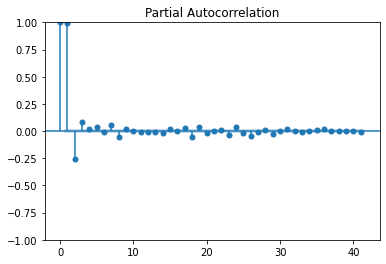

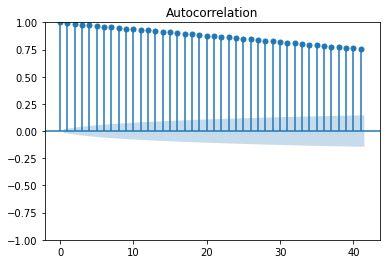

ADF Statistic: -6.297501014119232
p-value: 3.476786019979305e-08


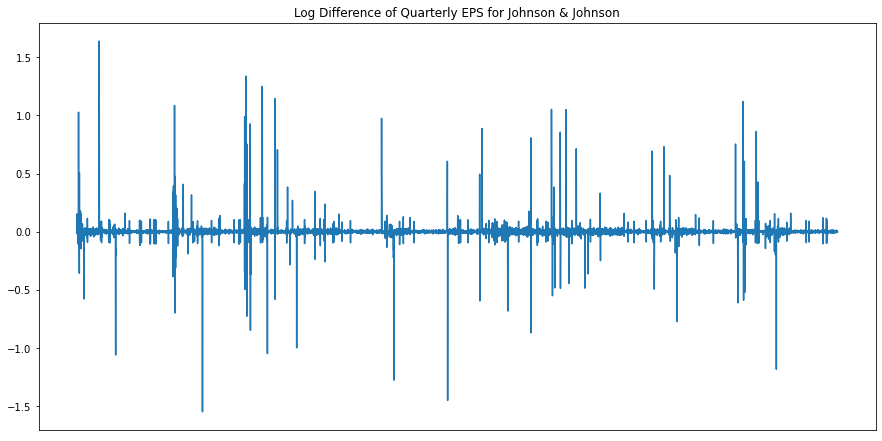

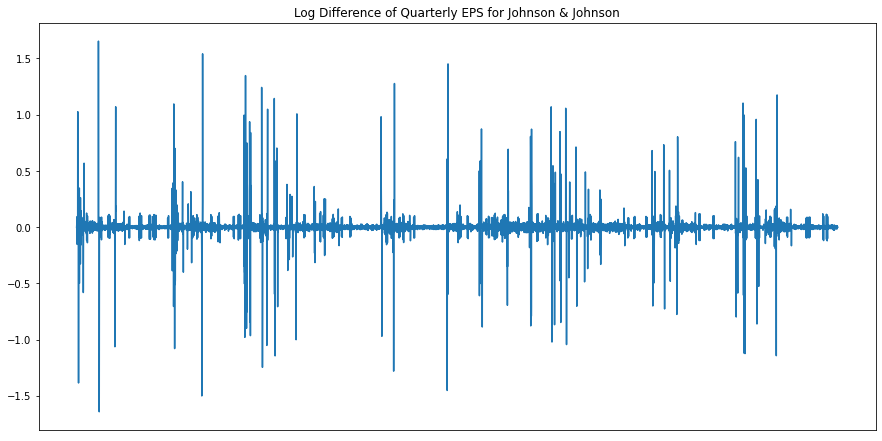

ADF Statistic: -25.12516632576006
p-value: 0.0
256


  0%|          | 0/256 [00:00<?, ?it/s]

      (p,q)x(P,Q)           AIC
0    (3, 2, 3, 3) -25821.248175
1    (2, 2, 3, 3) -25716.580725
2    (1, 2, 3, 3) -25589.725799
3    (1, 3, 3, 3) -25576.277378
4    (2, 2, 2, 3) -25517.829699
..            ...           ...
251  (0, 0, 2, 0) -10270.014965
252  (3, 0, 0, 0)  -8393.942156
253  (2, 0, 0, 0)  -8313.176834
254  (1, 0, 0, 0)  -7862.159401
255  (0, 0, 0, 0)  -6585.891179

[256 rows x 2 columns]


'\n#Splitting the dataset into training and testing \nX = series[seriesName]\ntrain, test = X[0:trainSize], X[trainSize:trainSize+testSize]\nhistory = [x for x in train]\npredictions = list()\n\nprint("\nTraining the model...\n")\n\nmaxLen = len(test)\n\n#creating SARIMA model\nmy_order = (0, 0, 0)\nmy_seasonal_order = (1, 1, 0, 12)\n# define model\n\nmodel = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)\n\nmodel_fit = model.fit()\n\n# plot forecasts against actual outcomes\nyhat = model_fit.predict(start=0, end=len(test))\n#print(yhat)\npredictions = list()\n\nfor value in yhat[1:]:\n    predictions.append(value)\n\nprint("Testing...")\n\n\nfc_series = pd.Series(predictions,index=test.index)\n\n# evaluate forecasts\nprint(forecast_accuracy(fc_series.values, test.values))\n\n\nplt.figure(figsize=(12,5), dpi=100)\nplt.plot(train, color=\'blue\')\nplt.plot(test, color=\'blue\')\nplt.plot(fc_series, color=\'red\')\nday = trainSize / 1440\nplt.title(seriesName + " " + st

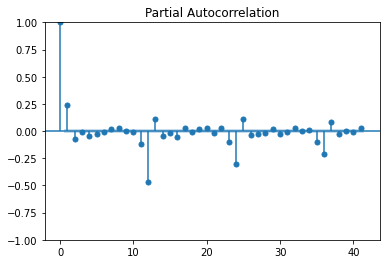

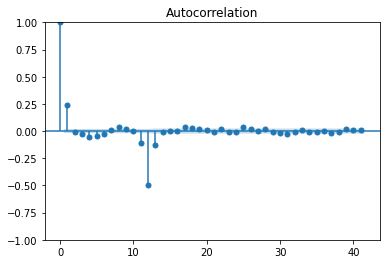

In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import os
import enum
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm_notebook

from itertools import product
import warnings
warnings.filterwarnings('ignore')


class TrainignTimeType(enum.IntEnum):
	ONE_WEEK = 10080
	ONE_MONTH = 43200

class TestingTimeType(enum.IntEnum):
	ONE_DAY = 1440

#Save the time series given as parameter 
def save_series_to_csv(series, fileName):
	path = "results/SARIMA" + originFileName[:-4]

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	path = "results/SARIMA" + originFileName[:-4] + "/" + seriesName

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	day = trainSize / 1440
	file = open(path + "/" + str(int(day)) + "days_" + fileName, "w")
	file.write(series.to_csv(header=False))
	file.close()

#Save the plot from pyplot
def save_plot():
	path = "results/SARIMA" + originFileName[:-4]

	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	path = "results/SARIMA" + originFileName[:-4] + "/" + seriesName
	if not os.path.isdir(path):
		try:
			os.mkdir(path)
		except OSError:
			print("Creation of the directory %s failed" % path)

	day = trainSize / 1440
	finalPath = path + "/" + str(int(day)) + "days_plot.png"
	plt.savefig(finalPath, dpi=100)

#Parser for the read_csv
def parser(x):
	return datetime.strptime(x, '%y-%m-%d %H:%M:%S')

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 
            'corr':corr, 'minmax':minmax})


'''
	PUT HERE THE CONFIGURATION VALUES
										'''
trainSize = TrainignTimeType.ONE_WEEK
testSize = TestingTimeType.ONE_DAY

originFileName = "ukdale_def4.csv"
seriesName = "Tv_Dvd_Lamp"



#main function
numbersOfRowToRead = int(trainSize) + int(testSize)

#Reading the series from the dataset file
series = read_csv("Dataset/" + originFileName,header=0,index_col=0,nrows=numbersOfRowToRead)
#print(series[seriesName].head())

plot_pacf(series[seriesName]);
plt.show()
plot_acf(series[seriesName]);
plt.show()

ad_fuller_result = adfuller(series[seriesName])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

series[seriesName] = np.log(series[seriesName])
series[seriesName] = series[seriesName].diff()
series = series.drop(series.index[0])

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(series[seriesName])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

# Seasonal differencing
series[seriesName] = series[seriesName].diff(12)
series = series.dropna().reset_index(drop=True)

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(series[seriesName])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

ad_fuller_result = adfuller(series[seriesName])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

plot_pacf(series[seriesName]);
plot_acf(series[seriesName]);

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, 1, 1, 4, series[seriesName])
print(result_df)


"""
#Splitting the dataset into training and testing 
X = series[seriesName]
train, test = X[0:trainSize], X[trainSize:trainSize+testSize]
history = [x for x in train]
predictions = list()

print("\nTraining the model...\n")

maxLen = len(test)

#creating SARIMA model
my_order = (0, 0, 0)
my_seasonal_order = (1, 1, 0, 12)
# define model

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

model_fit = model.fit()

# plot forecasts against actual outcomes
yhat = model_fit.predict(start=0, end=len(test))
#print(yhat)
predictions = list()

for value in yhat[1:]:
    predictions.append(value)

print("Testing...")


fc_series = pd.Series(predictions,index=test.index)

# evaluate forecasts
print(forecast_accuracy(fc_series.values, test.values))


plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, color='blue')
plt.plot(test, color='blue')
plt.plot(fc_series, color='red')
day = trainSize / 1440
plt.title(seriesName + " " + str(int(day)) + " days trained")
#pyplot.xticks(rotation=90)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

#saving date
#save_series_to_csv(train, "train.csv")
#save_series_to_csv(test, "test.csv")
#save_series_to_csv(fc_series, "predictions.csv")
#save_plot()

plt.show()

print("\nAll done!\n")
"""

In [18]:

f = open("sarima.txt", "w")
f.write(str(result_df.values))
f.close()
"""
type(result_df)

for p in range(0, 255):
    print(result_df[p])
    """

'\ntype(result_df)\n\nfor p in range(0, 255):\n    print(result_df[p])\n    '